In [1]:
import duckdb
import numpy as np
import pandas as pd

In [2]:
with duckdb.connect("../Data/capstone.db") as con:
    df = con.sql("select * from preprocessed_churn").df()

In [3]:
df.head()

,id,age,tenure,service_type,avg_call_duration,data_usage,roaming_usage,monthly_charge,overdue_payments,auto_payment,...,satisfaction_score,churn,İzleGo,RitimGo,CüzdanX,HızlıPazar,Konuşalım,Prepaid,Broadband,Postpaid
0,bf7ff6b6-5f13-48e6-8622-f0e3d68df951,32,162.0,Broadband,0.000000,162.00,0.00,281.63,3,1,...,2.66,0,0,0,0,0,0,0,1,0
1,a5d84084-eab8-427d-8fe8-b3cb2f038322,18,247.0,Prepaid,99.280000,60.68,44.00,717.59,0,0,...,1.97,0,0,0,0,0,0,1,0,0
2,186a48ba-5e69-4598-b520-b0f080fc8c3d,29,240.0,Prepaid,29.090000,58.79,2.96,840.83,0,0,...,9.70,0,0,0,0,0,1,1,0,0
3,28fc770f-26e3-4c1b-a34a-e352a178babc,28,139.0,Prepaid,35.430000,76.22,54.83,2456.37,0,0,...,7.82,0,0,0,0,0,1,1,0,0
4,9c68ea18-5381-464c-9641-a28b9e965494,51,159.0,Postpaid,60.627371,74.92,58.32,788.59,1,0,...,6.04,0,0,0,0,0,0,0,0,1


<Axes: ylabel='Frequency'>

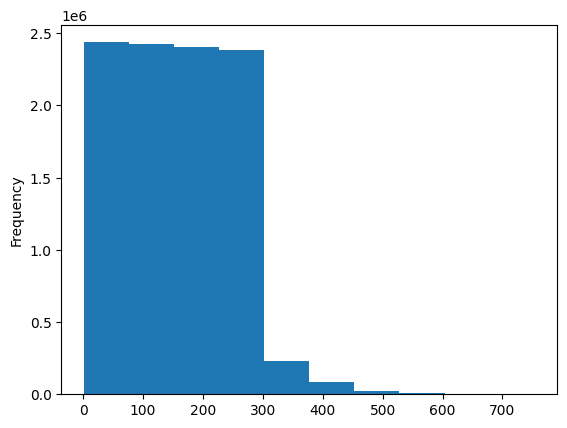

In [4]:
df["tenure"].plot.hist()

In [5]:
df["tenure/age"] = df["tenure"] / (df["age"]*12) 
df["age-tenure"] = (df["age"]*12) - df["tenure"]

<Axes: ylabel='Frequency'>

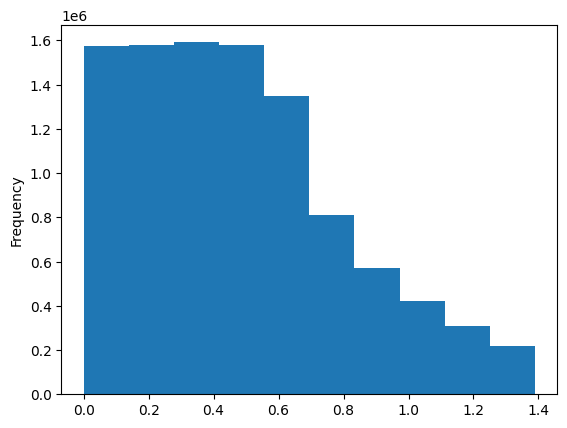

In [6]:
df["tenure/age"].plot.hist()

<Axes: ylabel='Frequency'>

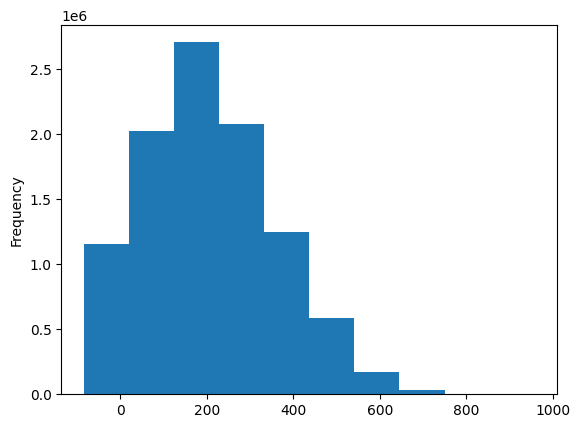

In [7]:
df["age-tenure"].plot.hist()

In [8]:
(df["age-tenure"] // 12).min()

-7.0

In [9]:
df = df[df["age-tenure"] > (18*12)] # outlier olarak değerlendireceğim 18 yaşından sonra müşteri olunabilir ancak veride -7 yaşında müşteri olmuş gibi görünen kişiler var

<Axes: ylabel='Frequency'>

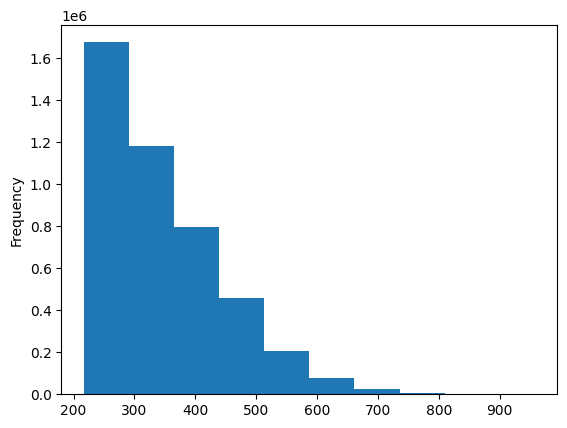

In [10]:
df["age-tenure"].plot.hist()

<Axes: ylabel='Frequency'>

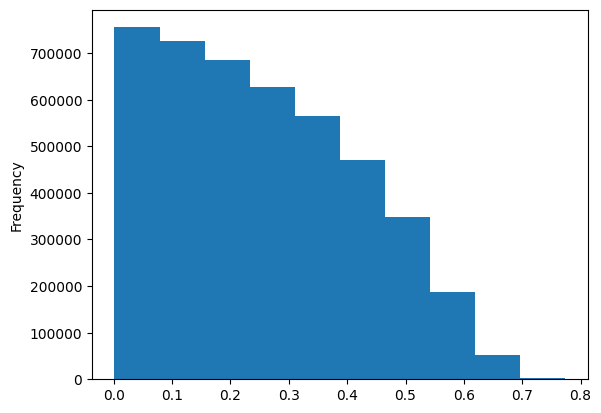

In [11]:
df["tenure/age"].plot.hist()

In [12]:
df["tenure"].describe()[["min", "25%","50%", "75%", "max"]]

min      1.0
25%     47.0
50%    106.0
75%    188.0
max    743.0
Name: tenure, dtype: float64

In [13]:
bins = [18, 25, 35, 45, 55, 65, np.inf]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

In [14]:
df['tenure_years'] = df['tenure'] / 12
df['tenure_group'] = pd.cut(df['tenure'], 
                           bins=[0, 47, 106, 188, 300, 500, np.inf],
                           labels=['0, 47', '48-106','107-188', '189-300', '301-500', '501-inf'],
                           right=False)
df['tenure_squared'] = df['tenure'] ** 2

In [15]:
df['data_efficiency'] = df['data_usage'] / (df['monthly_charge'] + 1e-6)  # +1e-6 division by zero koruması
df['has_roaming'] = df['roaming_usage'].apply(lambda x: 1 if x > 0 else 0)
df['overdue_frequency'] = df['overdue_payments'] / (df['tenure'] + 1e-6)
df['call_drop_rate'] = df['call_drops'] / (df['tenure'] + 1e-6)
df['support_call_rate'] = df['customer_support_calls'] / (df['tenure'] + 1e-6)

In [16]:
for service in df['service_type'].unique():
    df[f'{service}_data_interaction'] = df[service] * df['data_usage']

In [17]:
df['auto_payment_overdue'] = df['auto_payment'] * df['overdue_payments']
df['satisfaction_support_interaction'] = df['satisfaction_score'] * df['customer_support_calls']

In [18]:
df['any_overdue'] = df['overdue_payments'].apply(lambda x: 1 if x > 0 else 0)
df['high_cost'] = np.where(df['monthly_charge'] > df['monthly_charge'].quantile(0.75), 1, 0)
median_calls = df['customer_support_calls'].median()
df['low_satisfaction_high_support'] = np.where((df['satisfaction_score'] < 3) & 
                                              (df['customer_support_calls'] > median_calls), 1, 0)

In [19]:
df['is_prepaid'] = df['service_type'].apply(lambda x: 1 if x == 'Prepaid' else 0)
df['prepaid_top_ups'] = df['is_prepaid'] * df['avg_top_up_count']

In [20]:
df['voice_data_ratio'] = df['avg_call_duration'] / (df['data_usage'] + 1)

In [21]:
df['age_squared'] = df['age'] ** 2

In [22]:
tenure_dummies  = pd.get_dummies(df["tenure_group"])
age_dummies  = pd.get_dummies(df["age_group"])
df = pd.concat([df, tenure_dummies, age_dummies], axis=1)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4422491 entries, 0 to 9999999
Data columns (total 58 columns):
 #   Column                            Dtype   
---  ------                            -----   
 0   id                                object  
 1   age                               int64   
 2   tenure                            float64 
 3   service_type                      object  
 4   avg_call_duration                 float64 
 5   data_usage                        float64 
 6   roaming_usage                     float64 
 7   monthly_charge                    float64 
 8   overdue_payments                  int64   
 9   auto_payment                      int32   
 10  avg_top_up_count                  int64   
 11  call_drops                        float64 
 12  customer_support_calls            int64   
 13  satisfaction_score                float64 
 14  churn                             int32   
 15  İzleGo                            int32   
 16  RitimGo                

In [1]:
path = "../Data/capstone_final.csv"

In [25]:
df.to_csv(path)